In [150]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat

In [151]:
config()

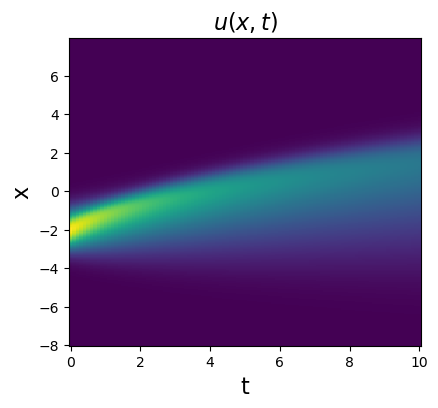

In [152]:
path = os.getcwd()
data_path = path.replace("examples", "tests/data")
data = loadmat(os.path.join(data_path, 'burgers.mat'))
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
delta_t = t[1] - t[0]
delta_x = x[1] - x[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

In [153]:
print(u.shape)
print(len(t))
print(len(x))
print(delta_t)

(256, 101)
101
256
0.1


In [154]:
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [166]:
def main_run(u, S, epsilon, max_time_iter):
    for t in range(max_time_iter):
        u_coch = C.CochainP0(S, u[:,t])
        flux = C.scalar_mul(C.square(u_coch), -1/2)
        mean_flux = flat(flux)
        dissipation = C.scalar_mul(C.coboundary(C.star(u_coch)), epsilon)
        total_flux = C.add(C.star(mean_flux), dissipation)
        balance = C.star(C.coboundary(total_flux))
        u[1:-1,t+1] = 1/2*(u[2:,t] + u[:-2,t]) - delta_t*balance.coeffs[1:-1]
    return u

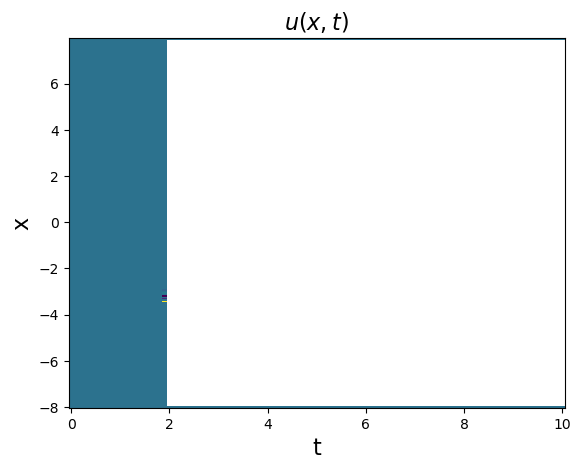

In [165]:
#u = 0.1*np.ones((len(x), len(t)), dtype = dt.float_dtype)
u_0 = u.copy()
# boundary conditions
u_0[:,0] = u[:,0]
u_0[0,:] = u[0,:]
u_0[-1,:] = u[-1,:]
epsilon = 0.1
max_time_iter = 100
u_sol = main_run(u_0, S, epsilon, max_time_iter)
plt.pcolormesh(time, x, u_sol)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()